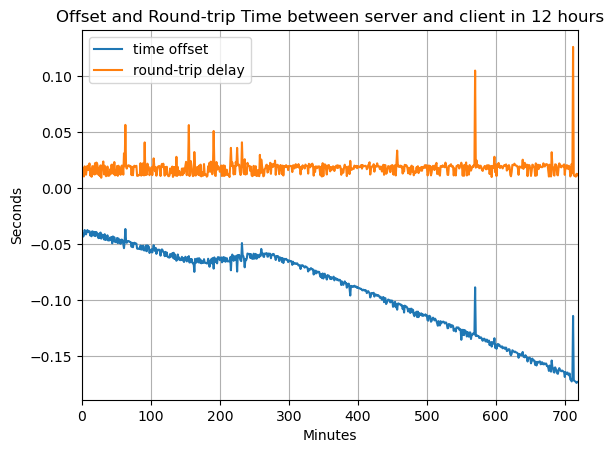

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def read_data(filename):
    with open(filename, 'r') as file:
        next(file)
        contents = file.readlines()
        
    output = []
    for line in contents:
        m, o, r = line.strip().split()
        output.append([float(m), float(o), float(r)])
    
    return np.array(output).T

# Offset is the time difference, RTT is the delay
time, offset, rtt = read_data('sat_data.txt')
start = time[0]
time -= start
plt.plot(time, offset, label='time offset')
plt.plot(time, rtt, label='round-trip delay')
plt.title('Offset and Round-trip Time between server and client in 12 hours')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Minutes')
plt.xlim([0, max(time)])
plt.ylabel('Seconds')
plt.grid(True)
plt.legend()
plt.show()

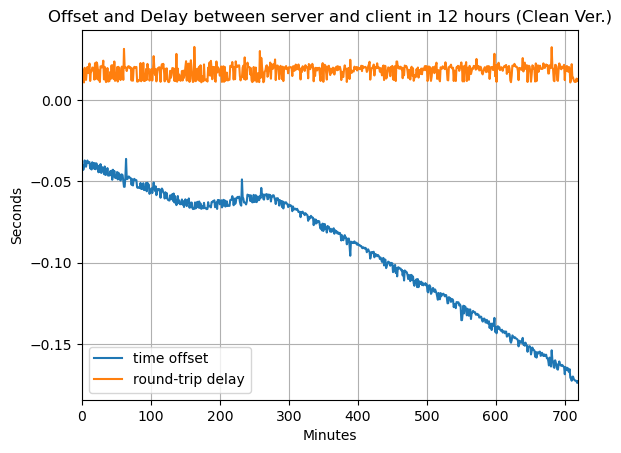

In [109]:
def replace_outliers(arr, num_to_replace):
    if not arr or num_to_replace <= 0:
        raise ValueError("The input array must not be empty, and num_to_replace must be a positive integer.")

    # Create a copy of the array to avoid modifying the original array
    arr_copy = arr.copy()

    # Find the unique biggest and smallest values in the array
    sorted_values = sorted(set(arr_copy))
    biggest_values = sorted_values[-num_to_replace:]
    smallest_values = sorted_values[:num_to_replace]

    # Replace the biggest and smallest values with their previous elements in the copy
    for i in range(len(arr_copy)):
        if arr_copy[i] in biggest_values or arr_copy[i] in smallest_values:
            # Get the index of the current value in the original array
            idx_in_original = arr.index(arr_copy[i])
            # Replace with the previous value if available, otherwise keep the original value
            arr_copy[i] = arr[idx_in_original - 1] if idx_in_original > 0 else arr_copy[0]

    return arr_copy

time, offset, rtt = read_data('sat_data.txt')
start = time[0]
time -= start
# NumPy arrays are immutable, so you cannot directly remove elements in place. Convert to Python lists
time_diff = list(offset)
delay = list(rtt)

delay = replace_outliers(delay,10)
time_diff[60:300] = replace_outliers(time_diff[60:300], 7)
time_diff[550:] = replace_outliers(time_diff[550:],3)

plt.plot(time, time_diff, label='time offset')
plt.plot(time, delay, label='round-trip delay')
plt.title('Offset and Delay between server and client in 12 hours (Clean Ver.)')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Minutes')
plt.xlim([0, max(time)])
plt.ylabel('Seconds')
plt.grid(True)
plt.legend()
plt.show()

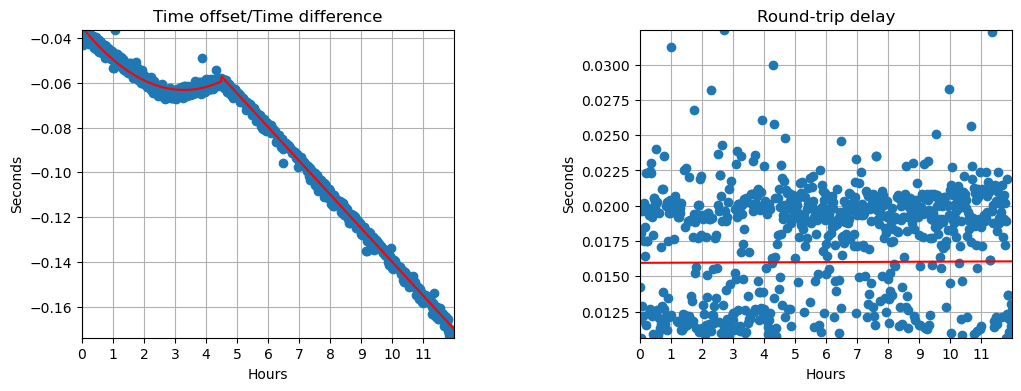

In [110]:
def merge_arrays(arrays_list):
    # Concatenate all arrays in the list to merge them into one
    merged_array = np.concatenate(arrays_list)
    return merged_array

# Find coefficients for least squares fitted line
coeffs11 = np.polyfit(time[:270], time_diff[:270], deg=2)
model11 = np.polyval(coeffs11, time[:270])
resid11 = time_diff[:270] - model11
coeffs12 = np.polyfit(time[270:], time_diff[270:], deg=1)
model12 = np.polyval(coeffs12, time[270:])
resid12 = time_diff[270:] - model12

model1 = merge_arrays([model11, model12])
resid1 = merge_arrays([resid11, resid12])

coeffs2 = np.polyfit(time, delay, deg=2)
model2 = np.polyval(coeffs2, time)
resid2 = delay - model2

time /= 60

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(time, time_diff, 'o')
ax[0].plot(time, model1, color='red')
ax[0].set_xlabel('Hours')
ax[0].set_xlim([0, max(time)])
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].set_ylabel('Seconds')
ax[0].set_ylim([min(time_diff), max(time_diff)])
# ax[0].yaxis.set_major_locator(ticker.MultipleLocator())
ax[0].yaxis.get_major_formatter().set_useOffset(False)
ax[0].set_title('Time offset/Time difference')
ax[0].grid('on', 'both')

ax[1].plot(time, delay, 'o')
ax[1].plot(model2, color='red')
ax[1].set_xlabel('Hours')
ax[1].set_xlim([0, max(time)])
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].set_ylabel('Seconds')
ax[1].set_ylim([min(delay), max(delay)])
# ax[1].yaxis.set_major_locator(ticker.MultipleLocator())
ax[1].yaxis.get_major_formatter().set_useOffset(False)
ax[1].set_title('Round-trip delay')
ax[1].grid('on', 'both')

plt.subplots_adjust(wspace=0.5)
plt.show()

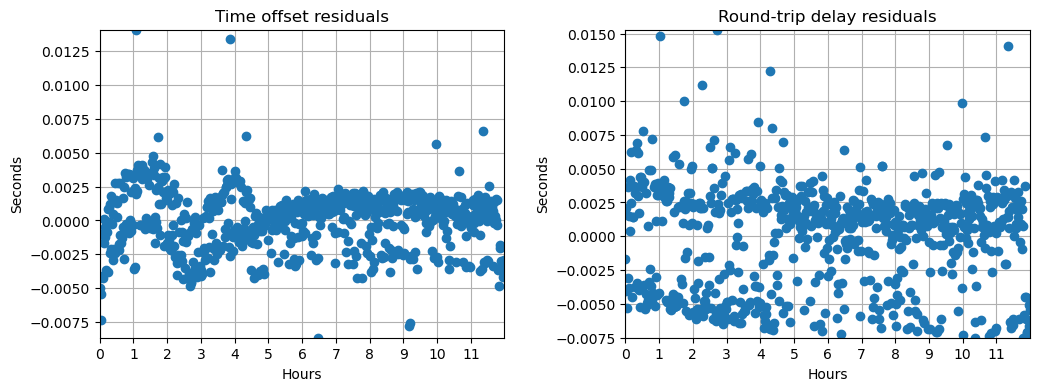

In [111]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(time, resid1, 'o')
ax[0].set_xlabel('Hours')
ax[0].set_xlim([min(time), max(time)])
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].set_ylabel('Seconds')
ax[0].set_ylim([min(resid1), max(resid1)])
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.0025))
ax[0].set_title('Time offset residuals')
ax[0].grid('on', 'both')

ax[1].plot(time, resid2, 'o')
ax[1].set_xlabel('Hours')
ax[1].set_xlim([min(time), max(time)])
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].set_ylabel('Seconds')
ax[1].set_ylim([min(resid2), max(resid2)])
ax[1].yaxis.set_major_locator(ticker.MultipleLocator(0.0025))
ax[1].set_title('Round-trip delay residuals')
ax[1].grid('on', 'both')

plt.subplots_adjust(wspace=0.3)
plt.show()

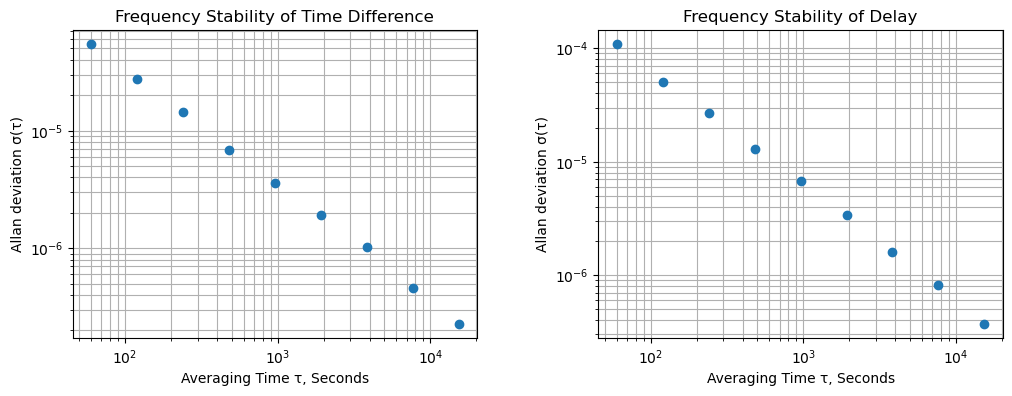

In [112]:
import allantools

taus1, allan_var1, _, _ = allantools.oadev(resid1, rate=1/60, data_type='phase') # 1-min intervals 
taus2, allan_var2, _, _ = allantools.oadev(resid2, rate=1/60, data_type='phase') # 1 sec = 1/60 minutes

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].loglog(taus1, allan_var1, 'o')
ax[0].set_xlabel('Averaging Time τ, Seconds')
ax[0].set_ylabel('Allan deviation σ(τ)')
# ax[0].set_ylim([1e-7, 1e-4])
ax[0].set_title('Frequency Stability of Time Difference')
ax[0].grid('on', 'both')

ax[1].loglog(taus2, allan_var2, 'o')
ax[1].set_xlabel('Averaging Time τ, Seconds')
ax[1].set_ylabel('Allan deviation σ(τ)')
# ax[1].set_ylim([1e-7, 1e-4])
ax[1].set_title('Frequency Stability of Delay')
ax[1].grid('on', 'both')

plt.subplots_adjust(wspace=0.3)
plt.show()